In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
%matplotlib inline
import time
from scipy.optimize import minimize
import os

plt.rcParams['text.usetex'] = True
plt.rcParams['axes.labelsize'] = 17.
plt.rcParams['legend.fontsize']=18.
plt.rcParams['axes.titlesize']=18.
plt.rcParams['legend.frameon'] = 'False'
plt.rcParams['legend.fontsize']=10
plt.rcParams['xtick.labelsize']=13.
plt.rcParams['ytick.labelsize']=13.
plt.rcParams['legend.numpoints']=1

In [2]:
base="./Oct30_2017/AT48888/BW Slices 1p4 Micron per Pixel/Direction_2_Slice_00"
ext=".tiff"
n_files=185
im=[]
for i in range(1,n_files+1):
    if i<10:
        im+=[Image.open(base+'00'+str(i)+ext)]
    elif i<100:
        im+=[Image.open(base+'0'+str(i)+ext)]
    else:
        im+=[Image.open(base+str(i)+ext)]
    
    im[i-1]=np.array(im[i-1])
    im[i-1][im[i-1]==255]=1

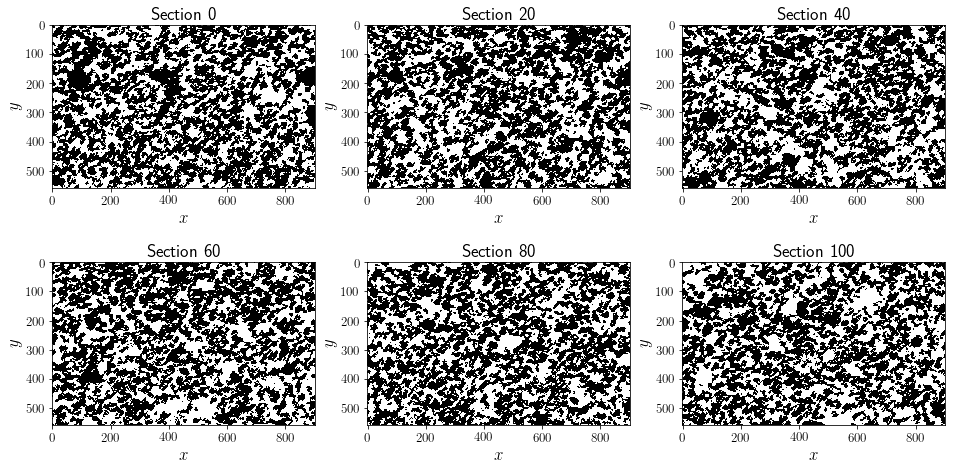

In [3]:
fig,ax=plt.subplots(2,3,figsize=(16,8))
some_files=[0,20,40,60,80,100]
for i, ax_i in enumerate(np.reshape(ax,6)):
    ax_i.imshow(im[some_files[i]],cmap=plt.get_cmap('binary'));
    ax_i.set_title('Section '+str(some_files[i]))
    ax_i.set_xlabel(r'$x$')
    ax_i.set_ylabel(r'$y$')

Black is 1. White is 0.

In [4]:
print('{0:.3f} of the medium is black.'.format(np.mean(im)))

0.552 of the medium is black.


# Naive estimation of S3 in frequency domain:

An estimate of $S_3$ is obtained from the 4D inverse discrete Fourier transform (DFT), i.e. 

$$\widehat{S}_3(\Delta{x_1},\Delta{y_1},\Delta{x_2},\Delta{y_2}):=\mathrm{DF}^{-1}_4[hS3(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})]$$

of

$$ hS3(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2}):= hI(\omega_{x_1},\omega_{y_1})\;hI(\omega_{x_2},\omega_{y_2})\;hI^*(\omega_{x_1}+\omega_{x_2},\omega_{y_1}+\omega_{y_2})$$

in which

$$ 
hI(\omega_{x},\omega_{y}):= \mathrm{DF}_2[I(x,y)]\;\;\mathrm{with}\;\;
(\omega_x,\omega_y)\in[-N_x/2+1,N_x/2]\times[0,N_y/2]$$

is the discrete Fourier transform  of 

$$
I(x,y)\;\mathrm{for}\;
(x,y)\in[0,N_x-1]\times[0,N_y-1].
$$

In order to compute $ hS3(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})$ so that $S_3(\Delta x_1,\Delta y_1,\Delta x_2,\Delta y_2)$ is known for $(\Delta x_1,\Delta y_1,\Delta x_2,\Delta y_2)\in[0,N_x-1]\times[0,N_y-1]\times[0,N_x-1]\times[0,N_y-1]$, we need to know

$$
hI(\omega_{x_1}+\omega_{x_2},\omega_{y_1}+\omega_{y_2})\;\;\mathrm{for}\;(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})\in[-N_x/2+1,N_x/2]\times[-N_y/2+1,N_y/2]\times[-N_x/2+1,N_x/2]\times[0,N_y/2]
$$

or, equivalently,

$$
hI(\omega_{x},\omega_{y})\;\;\mathrm{for}\;(\omega_{x},\omega_{y})\in[-N_x+2,N_x]\times[-N_y/2+1,N_y]
$$

which, for some frequency pairs $(\omega_{x},\omega_{y})$, is not explicitely evaluated when computing the FFT $hI$.
To obtain those values, we can make use of the following symmetries,

\begin{align*}
1)&\; I\in\mathbb{R}\implies hI(\omega_{x},\omega_{y})=hI^*(-\omega_{x},-\omega_{y}).\\
2)&\; \mathrm{by\ definition\ of\ DF},\; hI(\omega_{x},\omega_{y})=hI(\omega_{x}+kN_x,\omega_{y})=hI(\omega_{x},\omega_{y}+\ell N_y)=hI(\omega_{x}+kN_x,\omega_{y}+\ell N_y)\;\;\forall\;k,\ell\in\mathbb{N}.
\end{align*}

Then, we can proceed as follows. For some fixed $(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})\in[-N_x/2+1,N_x/2]\times[-N_y/2+1,N_y/2]\times[-N_x/2+1,N_x/2]\times[0,N_y/2]$, let

\begin{align*}
a:=&\;\Re\{hI(\omega_{x_1},\omega_{y_1})\}\\
b:=&\;\Im\{hI(\omega_{x_1},\omega_{y_1})\}\\
c:=&\;\Re\{hI(\omega_{x_2},\omega_{y_2})\}\\
d:=&\;\Im\{hI(\omega_{x_2},\omega_{y_2})\}\\
e:=&\;\Re\{hI(\omega_{x_1}+\omega_{x_2},\omega_{y_1}+\omega_{y_2})\}\\
f:=&\;\Im\{hI(\omega_{x_1}+\omega_{x_2},\omega_{y_1}+\omega_{y_2})\}
\end{align*}

so that

\begin{align*}
\Re\{hS3(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})\}=&\;a\cdot c\cdot e+a\cdot d\cdot f+b\cdot c\cdot f-b\cdot d\cdot e,\\
\Im\{hS3(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})\}=&\;-a\cdot c\cdot f+a\cdot d\cdot e+b\cdot c\cdot e+b\cdot d\cdot f.
\end{align*}

However, as mentioned before, for some $(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})$, the values of $a,\dots,f$ need to be evaluated using symmetries of $hI$.

Note that the values $hI(\omega_{x},\omega_y)$ and $hS3(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})$ are stored in row-major 1D arrays which we also denote by $hI$ and $hS3$.
Thus, the mappings

\begin{align*}
f:&\;[-N_{\bullet}/2+1,N_\bullet/2]\rightarrow[0,N_\bullet-1]\\
:&\;\omega\mapsto \omega\;\;\;\;\;\;\;\;\;\;\,\mathrm{if}\; \omega\geq 0\\
&\;\hspace{1.05cm}\omega+N_{\bullet}\;\mathrm{if}\; \omega< 0
\end{align*}
and
\begin{align*}
g_2\circ f&\;:[-N_x/2+1,N_x/2]\times[0,N_y/2]\rightarrow [0,N_x(N_y/2+1)-1]\\
&\;:(\omega_{x_1},\omega_{y_1})\mapsto f(\omega_{y_1})+(N_y/2+1)f(\omega_{x_1})\\
g_4\circ f&\;:[-N_x/2+1,N_x/2]\times[-N_y/2+1,N_y/2]\times[-N_x/2+1,N_x/2]\times[0,N_y/2]\rightarrow [0,N_x^2N_y(N_y/2+1)-1]\\
&\;:(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})\mapsto f(\omega_{y_2})+(N_y/2+1)(f(\omega_{x_2})+N_x(f(\omega_{y_1})+N_yf(\omega_{x_1})))\\
\end{align*}

are such that

\begin{align*}
hI[g_2\circ f(\omega_{x_1},\omega_{y_1})]=&\;hI(\omega_{x_1},\omega_{y_1})\\
hS3[g_4\circ f(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})]=&\;hS3(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})\\
\end{align*}

The following is implemented (see C++ code),

1) Get $(a,b)$ for all $(\omega_{x_1},\omega_{y_1})\in[-N_x/2+1,N_x/2]\times[-N_y/2+1,N_y/2]$:

- $(\omega_{x_1},\omega_{y_1})\in[-N_x/2+1,N_x/2]\times[0,N_y/2]$:

\begin{align*}
a=&\;\Re\{hI(\omega_{x_1},\omega_{y_1})\}=\Re\{hI[g_2\circ f(\omega_{x_1},\omega_{y_1})]\}\\
b=&\;\Im\{hI(\omega_{x_1},\omega_{y_1})\}=\Im\{hI[g_2\circ f(\omega_{x_1},\omega_{y_1})]\}
\end{align*}

- $(\omega_{x_1},\omega_{y_1})\in[-N_x/2+1,N_x/2)\times[-N_y/2+1,0)$:

$$hI(\omega_{x_1},\omega_{y_1})=hI^*(-\omega_{x_1},-\omega_{y_1})
$$

and $(-\omega_{x_1},-\omega_{y_1})\in(-N_x/2,N_x/2-1]\times(0,N_y/2-1] \subset [-N_x/2+1,N_x/2]\times[0,N_y/2]$ so that

\begin{align*}
a=&\;\Re\{hI^*(-\omega_{x_1},-\omega_{y_1})\}
=\Re\{hI[g_2\circ f(-\omega_{x_1},-\omega_{y_1})]\}\\
b=&\;\Im\{hI^*(-\omega_{x_1},-\omega_{y_1})\}
=-\Im\{hI[g_2\circ f(-\omega_{x_1},-\omega_{y_1})]\}.
\end{align*}


- $(\omega_{x_1},\omega_{y_1})\in\{N_x/2\}\times[-N_y/2+1,0)$:

$$hI(\omega_{x_1},\omega_{y_1})=hI^*(-\omega_{x_1},-\omega_{y_1})=hI^*(N_x-\omega_{x_1},-\omega_{y_1})
$$

and $(N_x-\omega_{x_1},-\omega_{y_1})\in\{N_x/2\}\times(0,N_y/2-1] \subset [-N_x/2+1,N_x/2]\times[0,N_y/2]$ so that

\begin{align*}
a=&\;\Re\{hI^*(N_x-\omega_{x_1},-\omega_{y_1})\}
=\Re\{hI[g_2\circ f(N_x-\omega_{x_1},-\omega_{y_1})]\}\\
b=&\;\Im\{hI^*(N_x-\omega_{x_1},-\omega_{y_1})\}
=-\Im\{hI[g_2\circ f(N_x-\omega_{x_1},-\omega_{y_1})]\}.
\end{align*}

2) Get $(c,d)$ for all $(\omega_{x_2},\omega_{y_2})\in[-N_x/2+1,N_x/2]\times[0,N_y/2]$:

\begin{align*}
c=&\;\Re\{hI(\omega_{x_2},\omega_{y_2})\}=\Re\{hI[g_2\circ f(\omega_{x_2},\omega_{y_2})]\}\\
d=&\;\Im\{hI(\omega_{x_2},\omega_{y_2})\}=\Im\{hI[g_2\circ f(\omega_{x_2},\omega_{y_2})]\}
\end{align*}

3) Get $(e,f)$ for all $(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})\in[-N_x/2+1,N_x/2]\times[-N_y/2+1,N_y/2]\times[-N_x/2+1,N_x/2]\times[0,N_y/2]$:

First, let

\begin{align*}
\omega_{x}:=\left\{
\begin{matrix}
\omega_{x_1}+\omega_{x_2}+N_x & \mathrm{if}\;  \omega_{x_1}+\omega_{x_2}<-N_x/2+1,\hfill\\
\omega_{x_1}+\omega_{x_2}-N_x & \mathrm{if}\;  \omega_{x_1}+\omega_{x_2}>N_x/2,\hfill\\
\omega_{x_1}+\omega_{x_2}& \mathrm{otherwise}.\hfill
\end{matrix}
\right.
\end{align*}

and

\begin{align*}
\omega_{y}:=\left\{
\begin{matrix}
\omega_{y_1}+\omega_{y_2}-N_y & \mathrm{if}\;  \omega_{y_1}+\omega_{y_2}>N_y/2,\hfill\\
\omega_{y_1}+\omega_{y_2}& \mathrm{otherwise}.\hfill
\end{matrix}
\right.
\end{align*}

so that $(\omega_{x},\omega_{y})\in[-N_x/2+1,N_x/2]\times[-N_y/2+1,N_y/2]$.
Then, we proceed as follows:

- $(\omega_{x},\omega_{y})\in[-N_x/2+1,N_x/2]\times[0,N_y/2]$:

\begin{align*}
a=&\;\Re\{hI(\omega_{x},\omega_{y})\}=\Re\{hI[g_2\circ f(\omega_{x},\omega_{y})]\}\\
b=&\;\Im\{hI(\omega_{x},\omega_{y})\}=\Im\{hI[g_2\circ f(\omega_{x},\omega_{y})]\}
\end{align*}

- $(\omega_{x},\omega_{y})\in[-N_x/2+1,N_x/2)\times[-N_y/2+1,0)$:

$$hI(\omega_{x},\omega_{y})=hI^*(-\omega_{x},-\omega_{y})
$$

and $(-\omega_{x},-\omega_{y})\in(-N_x/2,N_x/2-1]\times(0,N_y/2-1] \subset [-N_x/2+1,N_x/2]\times[0,N_y/2]$ so that

\begin{align*}
a=&\;\Re\{hI^*(-\omega_{x},-\omega_{y})\}
=\Re\{hI[g_2\circ f(-\omega_{x},-\omega_{y})]\}\\
b=&\;\Im\{hI^*(-\omega_{x},-\omega_{y})\}
=-\Im\{hI[g_2\circ f(-\omega_{x},-\omega_{y})]\}.
\end{align*}


- $(\omega_{x},\omega_{y})\in\{N_x/2\}\times[-N_y/2+1,0)$:

$$hI(\omega_{x},\omega_{y})=hI^*(-\omega_{x},-\omega_{y})=hI^*(N_x-\omega_{x},-\omega_{y})
$$

and $(N_x-\omega_{x},-\omega_{y})\in\{N_x/2\}\times(0,N_y/2-1] \subset [-N_x/2+1,N_x/2]\times[0,N_y/2]$ so that

\begin{align*}
a=&\;\Re\{hI^*(N_x-\omega_{x},-\omega_{y})\}
=\Re\{hI[g_2\circ f(N_x-\omega_{x},-\omega_{y})]\}\\
b=&\;\Im\{hI^*(N_x-\omega_{x},-\omega_{y})\}
=-\Im\{hI[g_2\circ f(N_x-\omega_{x},-\omega_{y})]\}.
\end{align*}




The amount of memory required to store $hS3$ for a single 2D section of size $N_x\times N_y$ is $N_x^2N_y(N_y/2+1)=O((N_xN_y)^2)$.
For $N_x\times N_y= 560\times 920$, this amounts to more memory than what can reasonably be allocated on a personal computer.

In [31]:
# Write data of 0-th slice in a csv file
os.chdir('/home/nicolas/Dropbox/Git/npcf/')

fp=open('im00.csv','w')
for i in range(len(im[0])):
    for j in range(len(im[0][i])):
        fp.write(str(im[0][i][j]))
        if j<len(im[0][i])-1:
            fp.write(',')
        else:
            fp.write('\n')
fp.close()

Okay, let's test the implementation for 56x56 sub-slice starting from (x0,y0)=(0,0):

In [53]:
# Divide the slice into smaller sub-slices
nx_npcf=56;nnx_npcf=int(nx/nx_npcf)
ny_npcf=56;nny_npcf=int(ny/ny_npcf)
x0=0;y0=0

os.chdir('/home/nicolas/Dropbox/Git/npcf/')

S3_FFT=np.zeros(nx_npcf*ny_npcf)

t_S3_FFT=time.time()
verb=2
out=os.popen('./dist/Release/GNU-Linux/npcf '+str(nx_npcf)+' '+str(ny_npcf)+' '
             +str(x0)+' '+str(y0)+' '+str(verb)+' im00.csv')
print(out.read())
t_S3_FFT=time.time()-t_S3_FFT
print('Time: {0:.2f} sec.\n'.format(t_S3_FFT)) 




2D slice of data: 

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0
0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0

In [38]:
# Divide the all slice into smaller slices
nx_npcf=56;nnx_npcf=int(nx/nx_npcf)
ny_npcf=56;nny_npcf=int(ny/ny_npcf)

os.chdir('/home/nicolas/Dropbox/Git/npcf/')

S3_FFT=np.zeros(nx_npcf*ny_npcf)

verb=1

t_S3_FFT=time.time()
for ix in range(nnx_npcf):
    for jx in range(nny_npcf):
        out=os.popen('./dist/Release/GNU-Linux/npcf '+str(nx_npcf)+' '+str(ny_npcf)+' '
                     +str(ix*nx_npcf)+' '+str(jx*ny_npcf)+' '+str(verb)+' im00.csv')        
        print('Section #{0:d}/{1:d}: [x0,y0]x[x0+nx,y0+ny]=[{2:d},{3:d}]x[{4:d},{5:d}]'.format\
              (ix*nny_npcf+jx+1,nnx_npcf*nny_npcf,
               ix*nx_npcf,ix*nx_npcf+nx_npcf,
               jx*ny_npcf,jx*ny_npcf+ny_npcf)) 
        print(out.read())

t_S3_FFT=time.time()-t_S3_FFT        

Section #1/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[0,56]


Section #2/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[56,112]


Section #3/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[112,168]


Section #4/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[168,224]


Section #5/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[224,280]


Section #6/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[280,336]


Section #7/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[336,392]


Section #8/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[392,448]


Section #9/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[448,504]


Section #10/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[504,560]


Section #11/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[560,616]


Section #12/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[616,672]


Section #13/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[672,728]


Section #14/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[728,784]


Section #15/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[784,840]


Section #16/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[840,896]


Section #17/160: [x0,y0]x[x0+nx,y0+ny]=[56,112]x[0,56]


Section #18/160: [x0,y0]x[x0



Section #137/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[448,504]


Section #138/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[504,560]


Section #139/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[560,616]


Section #140/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[616,672]


Section #141/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[672,728]


Section #142/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[728,784]


Section #143/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[784,840]


Section #144/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[840,896]


Section #145/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[0,56]


Section #146/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[56,112]


Section #147/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[112,168]


Section #148/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[168,224]


Section #149/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[224,280]


Section #150/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[280,336]


Section #151/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[336,392]


Section #152/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[392,448]


Section #1

In [45]:
print('Total time: {0:.2f} sec.'.format(t_S3_FFT)) 
print('Number of sub-slices: {0:d}.'.format(nnx_npcf*nny_npcf)) 
print('Time: {0:.2f} sec per sub-slice.\n'.format(t_S3_FFT/(nnx_npcf*nny_npcf))) 

Total time: 289.93 sec.
Number of sub-slices: 160.
Time: 1.81 sec per sub-slice.

